In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [60]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/root/jupyter/SAs/batdongsan-datalake-v0-d1b3b2296e65.json'
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='batdongsan-datalake-v0')

In [61]:
# If want to read a csv data, there is an available google drive link in README.md file
# data = pd.read_csv('browsing behavior_v1.csv')

In [62]:
query="""
SELECT
  DISTINCT visit_date,
  full_visitor_id,
  hits_pagepath,
  COUNT(DISTINCT productSKU) AS view_listing_cnt,
  COUNT(DISTINCT productSKU)/20 AS srp_page_cnt,
FROM
  `batdongsan-datalake-v0.derived.ga_master_nested`
LEFT JOIN
  UNNEST (hits) AS hits
LEFT JOIN
  UNNEST(product) AS product
WHERE
  visit_date >= "2022-03-28"
  AND visit_date <= "2022-04-03"
  AND page_path_search_type IN ('Scope Search', 'Mix Search')
GROUP BY
  visit_date,
  full_visitor_id,
  hits_pagepath
"""
job = bigquery_client.query(query)
data = job.to_dataframe()

In [63]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
view_listing_cnt,2621219.0,20.888891,12.802470,0.0,20.0,20.0,20.0,2309.00
srp_page_cnt,2621219.0,1.044445,0.640124,0.0,1.0,1.0,1.0,115.45


<AxesSubplot:>

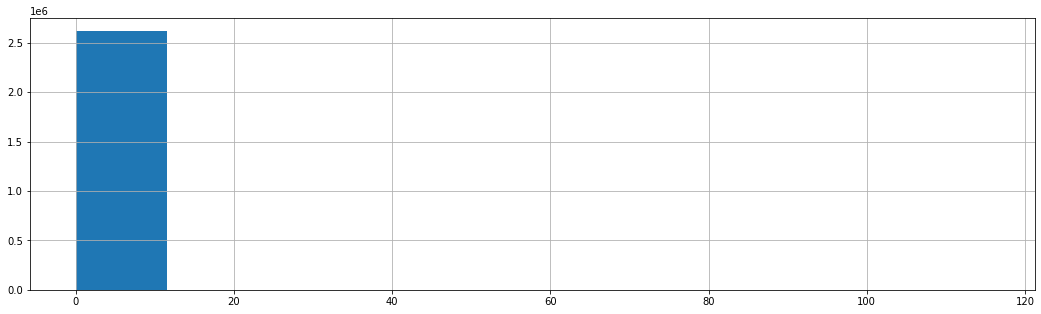

In [64]:
plt.figure(figsize=(18,5))
# plt.xticks(np.arange(0,10,1))
data['srp_page_cnt'].hist(bins=10)

<AxesSubplot:>

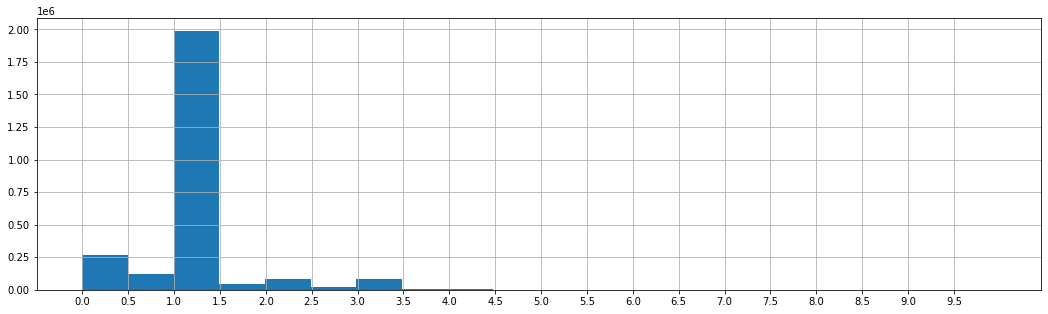

In [65]:
b3=data[data['srp_page_cnt'] < 10]
plt.figure(figsize=(18,5))
plt.xticks(np.arange(0,10,0.5))
b3['srp_page_cnt'].hist(bins=20)

In [66]:
data[data['srp_page_cnt'] <= 1].nunique()['full_visitor_id']/ data.nunique()['full_visitor_id']

0.9653159609454898

In [67]:
data[data['srp_page_cnt'] > 1][data['srp_page_cnt'] < 3].nunique()['full_visitor_id']/ data.nunique()['full_visitor_id']

<ipython-input-67-f718fc5b66ec>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['srp_page_cnt'] > 1][data['srp_page_cnt'] < 3].nunique()['full_visitor_id']/ data.nunique()['full_visitor_id']


0.15381595003855922

In [68]:
data[data['srp_page_cnt'] >= 3].nunique()['full_visitor_id']/ data.nunique()['full_visitor_id']

0.0456730923457728

In [69]:
# If want to read a csv data, there is an available google drive link in README.md file
# a = pd.read_csv('browsing behavior_v2.csv')

In [70]:
a = """SELECT
  DISTINCT visit_date,
  full_visitor_id,
  REGEXP_REPLACE(case when regexp_contains(hits_pagepath, r'#') then REGEXP_EXTRACT(hits_pagepath, r'(.*)#') else hits_pagepath end ,r'(/p\d+$)','') AS hits_pagepath,
  COUNT(DISTINCT productSKU) AS view_listing_cnt,
  COUNT(DISTINCT productSKU)/20 AS srp_page_cnt,
FROM
  `batdongsan-datalake-v0.derived.ga_master_nested`
LEFT JOIN
  UNNEST (hits) AS hits
LEFT JOIN
  UNNEST(product) AS product
WHERE
  visit_date >= "2022-03-28"
  AND visit_date <= "2022-04-03"
  AND page_path_search_type IN ('Scope Search', 'Mix Search')
GROUP BY
  visit_date,
  full_visitor_id,
  hits_pagepath
HAVING MIN(custom_SRP_result_count) >= 20 AND MIN(custom_SRP_result_count) IS NOT NULL"""
job = bigquery_client.query(a)
data2 = job.to_dataframe()

<AxesSubplot:>

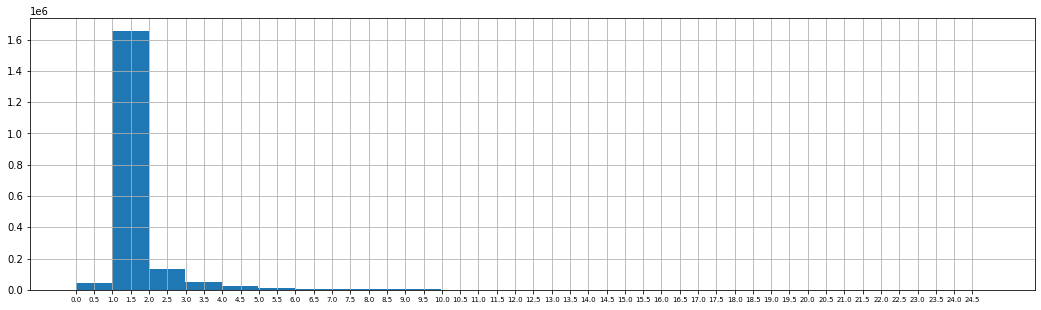

In [71]:
b=data2[data2['srp_page_cnt'] < 25]
plt.figure(figsize=(18,5))
plt.xticks(np.arange(0,25,0.5), fontsize=7)
b['srp_page_cnt'].hist(bins=25)

In [72]:
data2[data2['srp_page_cnt'] <= 1].count()['full_visitor_id']/ data2.count()['full_visitor_id']

0.8011780599837882

In [73]:
data2[data2['srp_page_cnt'] > 1][data2['srp_page_cnt'] < 3].count()['full_visitor_id']/ data2.count()['full_visitor_id']

<ipython-input-73-3ef21cc1e802>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2[data2['srp_page_cnt'] > 1][data2['srp_page_cnt'] < 3].count()['full_visitor_id']/ data2.count()['full_visitor_id']


0.14113508575545863

In [74]:
data2[data2['srp_page_cnt'] >= 3].count()['full_visitor_id']/ data2.count()['full_visitor_id']

0.057686854260753206

In [75]:
conditions = [(data2['srp_page_cnt'] <=1), (data2['srp_page_cnt'] < 3) & (data2['srp_page_cnt'] > 1), (data2['srp_page_cnt'] >=3)]
values = ['view 1 page', 'view 2 pages', 'view 3 pages+']
data2['pages_viewed_cnt']=np.select(conditions, values)
data2.head()

,visit_date,full_visitor_id,hits_pagepath,view_listing_cnt,srp_page_cnt,pages_viewed_cnt
0,2022-03-28,3905271862470816682,/nha-dat-ban-thi-tran-khoai-chau,20,1.0,view 1 page
1,2022-03-28,2498109687178815082,/ban-nha-mat-pho-phuong-khuong-mai,20,1.0,view 1 page
2,2022-03-28,4238474673676999944,/ban-can-ho-chung-cu-him-lam-cho-lon,20,1.0,view 1 page
3,2022-03-28,4245968927753187682,/ban-dat-xa-ninh-an,20,1.0,view 1 page
4,2022-03-28,6796443984135792023,/ban-nha-mat-pho-duong-bui-thi-xuan-391,20,1.0,view 1 page


In [76]:
data2.groupby(['pages_viewed_cnt','visit_date'])[['full_visitor_id']].count().unstack()

full_visitor_id                                              \
visit_date            2022-03-28 2022-03-29 2022-03-30 2022-03-31 2022-04-01   
pages_viewed_cnt                                                               
view 1 page               240861     230842     226790     231384     218290   
view 2 pages               42700      42448      43254      42751      38322   
view 3 pages+              16909      16265      17093      16633      16224   

                                        
visit_date       2022-04-02 2022-04-03  
pages_viewed_cnt                        
view 1 page          210182     198360  
view 2 pages          33635      31119  
view 3 pages+         14470      14493

In [77]:
data2.groupby(['pages_viewed_cnt','visit_date'])['full_visitor_id'].count().unstack()/data2.groupby('visit_date')['full_visitor_id'].count()

visit_date,2022-03-28,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03
pages_viewed_cnt,,,,,,,
view 1 page,0.801614,0.797230,0.789832,0.795768,0.800078,0.813754,0.813044
view 2 pages,0.142111,0.146597,0.150639,0.147028,0.140458,0.130223,0.127552
view 3 pages+,0.056275,0.056172,0.059529,0.057204,0.059464,0.056023,0.059404


In [78]:
conditions = [(data['srp_page_cnt'] <=1), (data['srp_page_cnt'] < 3) & (data['srp_page_cnt'] > 1), (data['srp_page_cnt'] >=3)]
values = ['view 1 page', 'view 2 pages', 'view 3 pages+']
data['pages_viewed_cnt']=np.select(conditions, values)
data.head()

,visit_date,full_visitor_id,hits_pagepath,view_listing_cnt,srp_page_cnt,pages_viewed_cnt
0,2022-03-28,8768290235964831189,/ban-dat-lang-giang-bg,20,1.0,view 1 page
1,2022-03-28,1710062284479418428,/nha-dat-ban-xa-dung-liet,20,1.0,view 1 page
2,2022-03-28,8211761993091029949,/cho-thue-nha-mat-pho-duong-pham-van-hai-69,20,1.0,view 1 page
3,2022-03-28,8756349582637603947,/ban-dat-xa-thuong-mo,20,1.0,view 1 page
4,2022-03-28,6120353605609677193,/ban-dat-xa-da-phuoc-1,38,1.9,view 2 pages


In [79]:
data.groupby(['pages_viewed_cnt','visit_date'])[['full_visitor_id']].count().unstack()

full_visitor_id                                              \
visit_date            2022-03-28 2022-03-29 2022-03-30 2022-03-31 2022-04-01   
pages_viewed_cnt                                                               
view 1 page               352921     340569     337274     341239     327890   
view 2 pages               40176      40030      40688      40238      34178   
view 3 pages+              13059      12305      13185      12819      12214   

                                        
visit_date       2022-04-02 2022-04-03  
pages_viewed_cnt                        
view 1 page          295772     277287  
view 2 pages          32016      29848  
view 3 pages+         12997      14514

In [80]:
data.groupby(['pages_viewed_cnt','visit_date'])['full_visitor_id'].count().unstack()/data.groupby('visit_date')['full_visitor_id'].count()

visit_date,2022-03-28,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03
pages_viewed_cnt,,,,,,,
view 1 page,0.868930,0.866800,0.862269,0.865439,0.876051,0.867914,0.862079
view 2 pages,0.098918,0.101882,0.104022,0.102050,0.091316,0.093948,0.092797
view 3 pages+,0.032153,0.031318,0.033709,0.032511,0.032633,0.038138,0.045124


In [81]:
# If want to read a csv data, there is an available google drive link in README.md file
# b = pd.read_csv('browsing behavior_v3.csv')

In [82]:
b = """WITH
  t1 AS (
  SELECT
    DISTINCT visit_date,
    full_visitor_id,
    hits_pagepath,
    REGEXP_EXTRACT(CASE
        WHEN REGEXP_CONTAINS(hits_pagepath, r'#') THEN REGEXP_EXTRACT(hits_pagepath, r'(.*)#')
      ELSE
      hits_pagepath
    END
      ,r'(/p\d+$)') AS page_num,
  FROM
    `batdongsan-datalake-v0.derived.ga_master_nested`
  LEFT JOIN
    UNNEST (hits) AS hits
  LEFT JOIN
    UNNEST(product) AS product
  WHERE
    visit_date >= "2022-03-28"
    AND visit_date <= "2022-04-03"
    AND page_path_search_type IN ('Scope Search',
      'Mix Search'))
SELECT
  visit_date,
  full_visitor_id,
  REGEXP_REPLACE(CASE
      WHEN REGEXP_CONTAINS(hits_pagepath, r'#') THEN REGEXP_EXTRACT(hits_pagepath, r'(.*)#')
    ELSE
    hits_pagepath
  END
    ,r'(/p\d+$)','') AS hits_pagepath,
  MAX(CASE WHEN CAST(REGEXP_EXTRACT(page_num, r'/p(.*)+$') AS int64) IS NULL THEN 1 ELSE CAST(REGEXP_EXTRACT(page_num, r'/p(.*)+$') AS int64) END) AS page
FROM
  t1
GROUP BY
  visit_date,
  full_visitor_id,
  hits_pagepath
"""
job = bigquery_client.query(b)
data3 = job.to_dataframe()

In [83]:
data3.head(10)

,visit_date,full_visitor_id,hits_pagepath,page
0,2022-04-03,8301826512395368274,/cho-thue-nha-rieng-ha-noi/gia-tu-1-trieu-den-...,1
1,2022-04-03,335139516684284179,/cho-thue-nha-mat-pho-tp-hcm,6
2,2022-04-03,9191122327370784510,/cho-thue-nha-tro-phong-tro-ha-noi/gia-tu-1-tr...,1
3,2022-04-03,53895690820622305,/nha-dat-cho-thue-quan-8/gia-tu-3-trieu-den-5-...,3
4,2022-04-03,1535481604872975674,/nha-dat-ban-ba-ria-vung-tau,1
5,2022-04-03,2281734586327055654,/ban-nha-rieng-pho-khuong-thuong-3,1
6,2022-04-03,335139516684284179,/cho-thue-nha-rieng-tp-hcm,5
7,2022-04-03,2865968988927054014,/cho-thue-can-ho-chung-cu-cau-giay/gia-tu-5-tr...,5
8,2022-04-03,5051046455604235459,/nha-dat-cho-thue-richmond-city,1
9,2022-04-03,5051046455604235459,/nha-dat-cho-thue,1


In [84]:
data3.groupby('page')[['full_visitor_id']].count()

,full_visitor_id
page,
0,5
1,1988193
2,67088
3,29662
4,44194
...,...
193710244,4
581130733,65
935209405,1


In [85]:
conditions = [(data3['page'] <=1), (data3['page'] < 3) & (data3['page'] > 1), (data3['page'] >=3)]
values = ['view 1 page', 'view 2 pages', 'view 3 pages+']
data3['pages_viewed_cnt']=np.select(conditions, values)
data3.head()

,visit_date,full_visitor_id,hits_pagepath,page,pages_viewed_cnt
0,2022-04-03,8301826512395368274,/cho-thue-nha-rieng-ha-noi/gia-tu-1-trieu-den-...,1,view 1 page
1,2022-04-03,335139516684284179,/cho-thue-nha-mat-pho-tp-hcm,6,view 3 pages+
2,2022-04-03,9191122327370784510,/cho-thue-nha-tro-phong-tro-ha-noi/gia-tu-1-tr...,1,view 1 page
3,2022-04-03,53895690820622305,/nha-dat-cho-thue-quan-8/gia-tu-3-trieu-den-5-...,3,view 3 pages+
4,2022-04-03,1535481604872975674,/nha-dat-ban-ba-ria-vung-tau,1,view 1 page


In [86]:
plot1=data3.groupby(['visit_date','pages_viewed_cnt'])[['full_visitor_id']].count()
plot1

full_visitor_id
visit_date pages_viewed_cnt                 
2022-03-28 view 1 page                309977
           view 2 pages                11322
           view 3 pages+               25903
2022-03-29 view 1 page                298677
           view 2 pages                11225
           view 3 pages+               25207
2022-03-30 view 1 page                299443
           view 2 pages                10714
           view 3 pages+               21595
2022-03-31 view 1 page                293406
           view 2 pages                11048
           view 3 pages+               29680
2022-04-01 view 1 page                279337
           view 2 pages                10367
           view 3 pages+               24576
2022-04-02 view 1 page                253377
           view 2 pages                 7170
           view 3 pages+               33262
2022-04-03 view 1 page                253981
           view 2 pages                 5242
           view 3 pages+               20781

In [87]:
data3.groupby(['pages_viewed_cnt','visit_date'])['full_visitor_id'].count().unstack(level=-1)/data3.groupby('visit_date')['full_visitor_id'].count()

visit_date,2022-03-28,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03
pages_viewed_cnt,,,,,,,
view 1 page,0.892786,0.891283,0.902611,0.878109,0.888816,0.862387,0.907062
view 2 pages,0.032609,0.033497,0.032295,0.033065,0.032987,0.024404,0.018721
view 3 pages+,0.074605,0.075220,0.065094,0.088827,0.078198,0.113210,0.074217


In [88]:
data4=data3.groupby('pages_viewed_cnt').agg(
    visitor_cnt = pd.NamedAgg(column='full_visitor_id', aggfunc = 'nunique'),
    url_cnt = pd.NamedAgg(column='hits_pagepath', aggfunc = 'nunique'),
    )
data4['url per visitor'] = (data4.visitor_cnt/data4.url_cnt).round(2).fillna(0)
data4.reset_index()
data4.head()

,visitor_cnt,url_cnt,url per visitor
pages_viewed_cnt,,,
view 1 page,680325,271145,2.51
view 2 pages,44654,14807,3.02
view 3 pages+,132731,11984,11.08


<Figure size 2160x720 with 0 Axes>

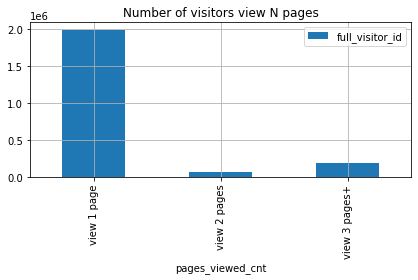

In [89]:
plot2=data3.groupby(['pages_viewed_cnt'])[['full_visitor_id']].count()
plot2
plt.figure(figsize=(30,10))
plot2.plot(kind='bar', title="Number of visitors view N pages", grid=True)
plt.tight_layout()